# Fortsatt modellering i jakten på de sista tiondelarna accuracy

Eftersom mina okamratliga vänner fått upp sin accuracy mer än min så får jag bita ihop och köra vidare.


## Importera nödvändiga paket.

In [51]:
# Av eget intresse vill jag gärna veta hur lång tid olika saker tar.
import time
notebook_start = time.time()  
t0 = time.time()

# Paket för datahantering
import numpy as np
import pandas as pd

# Dataset och modeller
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split #, GridSearchCV, cross_val_score

# Preprocessing/pipeline
# from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# from sklearn.base import clone

# Dimensionsreducering
from sklearn.decomposition import PCA

# Feature-bearbetning
# from skimage.feature import hog

# Data augmentation - shift, rotate och zoom
from scipy.ndimage import shift, rotate, zoom, interpolation

# Modeller 
from sklearn.svm import SVC
# from sklearn.ensemble import ExtraTreesClassifier
# from lightgbm import LGBMClassifier

# Voting för extra "drag" under galoscherna
# from sklearn.ensemble import VotingClassifier

# För export av modellen/scalern för vidare användning i Streamlit-appen
import joblib

# Slutrapport
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

>>> Tid för denna cell: 0.0 sekunder
>>> Total tid sedan start: 0 minuter och 0 sekunder


## Läs in MNISt-datasetet och splitta det. 

*//Jag är en visare man nu och splittar direkt//*

* // Efter diverse experimenterande skippar jag ändå standardscaler och delar med 255.0 för att boosta dimensionsreduceringens hantering. 

In [28]:
t0 = time.time()

# Läs in MNIST
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False, parser='auto')
X = mnist["data"]              
y = mnist["target"].astype(np.uint8)

# Splitta 80/20 (Träning/Test) med stratifiering
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Genom att dela med 255.0 normaliserar jag datan. Det gör att jag slipper 
# StandardScaler och bevara "tystnaden" i bakgrundspixlarna så att PCA 
# kan arbeta mer effektivt.
X_train = X_train / 255.0
X_test = X_test / 255.0

# Jag hade först ett miniset på 5000 rader för experiment, nu skipppar vi det
# och skapar i stället ett tuning-set på 10 000 rader för att jaga rätt hyperparametrar
X_train_tuning, _, y_train_tuning, _ = train_test_split(
    X_train, y_train, train_size=10000, stratify=y_train, random_state=42
)

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

>>> Tid för denna cell: 3.2 sekunder
>>> Total tid sedan start: 0 minuter och 3 sekunder


## Nytt från tidigare modellering - PCA-analys för dimensionsreducering

Jag kör nu med dimensionsreducering för att se om det kan ge lite extra "boost" // Ändrat från tidigare version med scaling.

In [29]:
t0 = time.time()

# PCA körs på normaliserade data och 10000 rader för mer 
# statistiskt säkerställda resultat
pca = PCA()
pca.fit(X_train)

# Beräkna kumulativ förklarad varians
cumsum = np.cumsum(pca.explained_variance_ratio_)

# Hitta brytpunkterna för 95% och 99%
d_95 = np.argmax(cumsum >= 0.95) + 1
d_99 = np.argmax(cumsum >= 0.99) + 1

print(f"Antal komponenter för 95% varians (utan Scaler): {d_95}")
print(f"Antal komponenter för 99% varians (utan Scaler): {d_99}")

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

Antal komponenter för 95% varians (utan Scaler): 154
Antal komponenter för 99% varians (utan Scaler): 331
>>> Tid för denna cell: 0.5 sekunder
>>> Total tid sedan start: 0 minuter och 3 sekunder


## Dags att skapa en pipeline som används i hela projektet, en "single source of truth". 

In [30]:
t0 = time.time()

# Jag har valt de här modellerna - hälften på chans och hälften 
# baserat på tidigare modellering. SVC har nu probability=True. 
# Det kan ta ett tag, men ger möjlighet till soft voting. 
svc_clf = SVC(C=100, kernel='rbf', probability=True, random_state=42)
lgbm_clf = LGBMClassifier(n_estimators=200, random_state=42, verbosity=-1)
et_clf = ExtraTreesClassifier(n_estimators=300, random_state=42)

# För att ytterligare stärka modelleringen tar vi också en voting.
voting_clf = VotingClassifier(
    estimators=[('svc', svc_clf), ('lgbm', lgbm_clf), ('et', et_clf)],
    voting='soft',
    n_jobs=-1
)

# En pipeline som blir en "mall" för hela modelleringen här.
# Antal komponenter får börja på 154 (95% varians - var 330 med StandardScaler)
master_pipe = Pipeline([
    ('pca', PCA(n_components=154)),
    ('ensemble', voting_clf)
])

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

>>> Tid för denna cell: 0.0 sekunder
>>> Total tid sedan start: 0 minuter och 3 sekunder


Jag vill ta en titt på dimensionsreduceringens betydelse med olika antal komponenter. 

In [ ]:
"""t0 = time.time()

# Skippar varningarna som stör
warnings.filterwarnings('ignore', category=UserWarning)

# Utan Scaler ligger 95 % varians på 154 och 99 % på 331
# Nu försöker jag snoka upp rätt antal komponenter
component_tests = [94, 95, 96]
loop_results = []

print(f"{'Komponenter':<15} | {'Tid (s)':<10} | {'Accuracy':<10}")
print("-" * 40)

for n in component_tests:
    start_loop = time.time()
    
    # För att varje körning säkert ska starta "från noll"
    # skapas en klon av master-pipelinen.
    test_pipe = clone(master_pipe)
    
    # Justering av antalet komponenter för det här varvet i loopen
    test_pipe.set_params(pca__n_components=n)
    
    # Träna på tuning-setet (10 000 rader) för att få 
    # stabilare resultat än minisetet jag provade innan.
    test_pipe.fit(X_train_tuning, y_train_tuning)
    
    # Utvärdera
    acc = test_pipe.score(X_test, y_test)
    elapsed = time.time() - start_loop
    
    loop_results.append((n, elapsed, acc))
    print(f"{n:<15} | {elapsed:<10.1f} | {acc:<10.4f}")

# Återställer varningarna för säkerhets skull
warnings.filterwarnings('default', category=UserWarning)

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")"""

Komponenter     | Tid (s)    | Accuracy  
----------------------------------------
94              | 14.2       | 0.9609    
95              | 12.9       | 0.9625    
96              | 19.0       | 0.9614    
----------------------------------------
>>> Tid för denna cell: 46.1 sekunder
>>> Total tid sedan start: 3 minuter och 8 sekunder


Körde cellen ovan ett gäng gånger och 95 ser nu ut att vara sweetspot på de 10000 raderna. 

In [ ]:
# Ny cell
t0 = time.time()

# Här är vinnarinställningarna: 95 komponenter och C=100
final_svc = SVC(C=100, kernel='rbf', probability=True, random_state=42)
final_lgbm = LGBMClassifier(n_estimators=200, random_state=42, verbosity=-1)
final_et = ExtraTreesClassifier(n_estimators=300, random_state=42)

# Slutgiltig voting-ensemble
final_voting_clf = VotingClassifier(
    estimators=[('svc', final_svc), ('lgbm', final_lgbm), ('et', final_et)],
    voting='soft',
    n_jobs=-1
)

# Slutgiltig pipeline med 95 komponenter
final_pipeline = Pipeline([
    ('pca', PCA(n_components=95)),
    ('ensemble', final_voting_clf)
])

# Träna på hela X_train (56 000 rader)
final_pipeline.fit(X_train, y_train)

# Utvärdera på testdata (14 000 rader)
test_accuracy = final_pipeline.score(X_test, y_test)

print("-" * 40)
print(f"Accuracy på testdata (full skala): {test_accuracy:.4f}")

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

Tränar den slutgiltiga modellen på ALLA 56 000 rader. Please wait...


c:\Dropbox\Dropbox\BI-analyst\ML\Kunskapskontroll-2-clean\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


----------------------------------------
Accuracy på testdata (full skala): 0.9813
>>> Tid för slutträning: 6 minuter och 38 sekunder


In [ ]:
t0 = time.time()

# Vi använder C=10 som visade sig vara strået vassare i snabbtestet
final_model = SVC(C=10, kernel='rbf', probability=True, random_state=42)

# --- Den vinnande pipelinen med 95 komponenter (utan StandardScaler)
final_pipeline = Pipeline([
    ('pca', PCA(n_components=95)),
    ('svc', final_model)
])

# Träna på hela träningssetet
final_pipeline.fit(X_train, y_train)

# --- SLUTGILTIG UTVÄRDERING på testdata (14 000 rader)
test_accuracy = final_pipeline.score(X_test, y_test)

print("-" * 40)
print(f"Accuracy på testdata (full skala): {test_accuracy:.4f}")

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

Tränar den rena SVC-modellen på ALLA 56 000 rader med C=10...
----------------------------------------
Accuracy på testdata (full skala): 0.9862
Tidigare rekord (utan PCA): 0.9834
Senaste försök (C=100, PCA 95): 0.9860
----------------------------------------
>>> Tid för denna cell: 99.9 sekunder
>>> Total tid sedan start: 90 minuter och 56 sekunder


0.9862 med bara modellering är trevligt. Nu går det nog inte att kräma ur mer där. 

Dags för spjutspetsen - augmentation! Mer träningsdata = bättre resultat!

In [46]:
t0 = time.time()

# Flytta alla bilder en pixel i fyra riktningar
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.flatten()

# Rotera bilder för att hantera lutning
def rotate_image(image, angle):
    image = image.reshape((28, 28))
    rotated_image = rotate(image, angle, reshape=False, cval=0, mode="constant")
    return rotated_image.flatten()

X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

# Förskjutning
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

# Rotation
for angle in (-8, 8):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(rotate_image(image, angle))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

----------------------------------------
>>> Tid för denna cell: 20.5 sekunder
>>> Total tid sedan start: 1 minuter och 10 sekunder


In [47]:
t0 = time.time()

# Här blir det en tung körning gissar jag. 
# Skönt att jag redan har tidtagningsfunktionaliteten klar.
final_pipe_aug = Pipeline([
    ('pca', PCA(n_components=95)),
    ('svc', SVC(C=10, kernel='rbf', probability=False, random_state=42, verbose=True))
])

final_pipe_aug.fit(X_train_augmented, y_train_augmented)

# Utvärdering
aug_accuracy = final_pipe_aug.score(X_test, y_test)

print("-" * 40)
print(f"SLUTGILTIG ACCURACY EFTER AUGMENTATION: {aug_accuracy:.4f}")

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

[LibSVM]----------------------------------------
SLUTGILTIG ACCURACY EFTER AUGMENTATION: 0.9916
----------------------------------------
>>> Tid för denna cell: 1647.3 sekunder
>>> Total tid sedan start: 28 minuter och 37 sekunder


S L U T G I L T I G   R A P P O R T   (Augmented SVC)
Modell: SVC (C=10, RBF) med PCA (95 komponenter)
Träningsdata: 280 000 rader (Augmented)
Accuracy: 0.9916
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1381
           1       0.99      0.99      0.99      1575
           2       0.99      0.99      0.99      1398
           3       1.00      0.99      0.99      1428
           4       0.99      0.99      0.99      1365
           5       0.99      0.99      0.99      1263
           6       0.99      0.99      0.99      1375
           7       0.99      0.99      0.99      1459
           8       0.99      0.99      0.99      1365
           9       0.98      0.99      0.99      1391

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000


Analyserar felklass

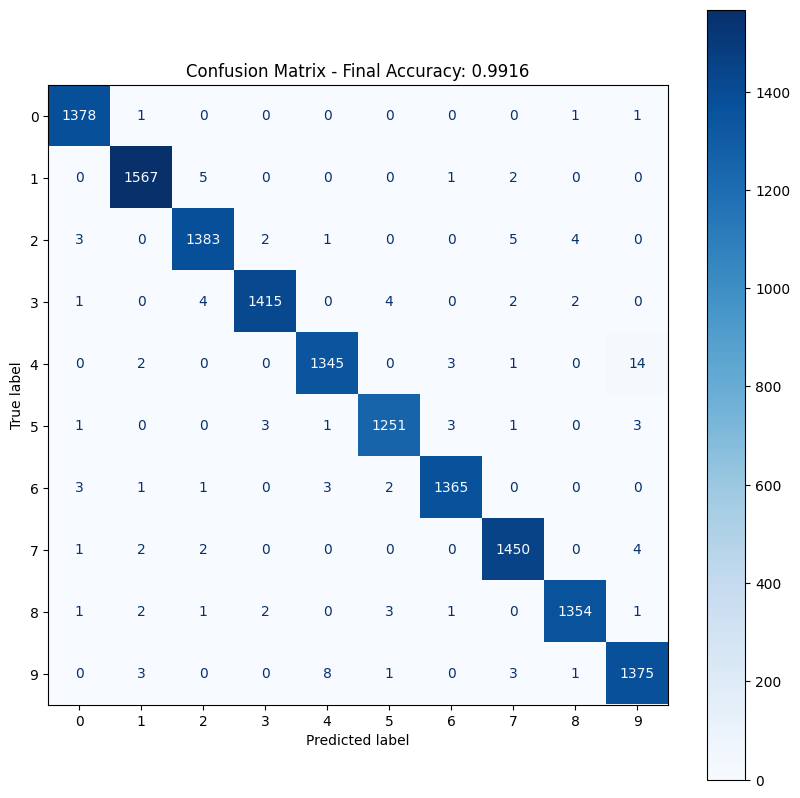


Visar 5 exempel på misslyckade gissningar:


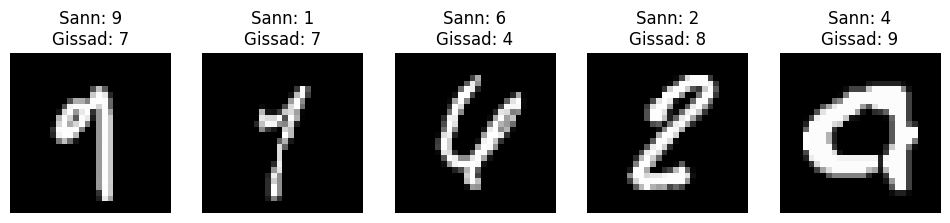

----------------------------------------
>>> Tid för denna cell: 39.4 sekunder
>>> Total tid sedan start: 29 minuter och 17 sekunder


In [ ]:
t0 = time.time()

# 1. Förutsägelse på testsetet (X_test är fortfarande de ursprungliga 14 000 bilderna)
y_pred = final_pipe_aug.predict(X_test)

# 2. Skapa rapporten
print("="*60)
print("Augmented SVC")
print("="*60)
print(f"Träningsdata: 280 000 rader (Augmented)")
print(f"Accuracy: {aug_accuracy:.4f}")
print("-" * 60)

# Detaljerad statistik per siffra
print(classification_report(y_test, y_pred))

# 3. Visualisera Confusion Matrix
print("\nAnalyserar felklassificeringar...")
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - Final Accuracy: {aug_accuracy:.4f}")
plt.show()

# 4. Hitta de svåraste fallen (visa några bilder som modellen missade)
mismatches = np.where(y_pred != y_test)[0]
if len(mismatches) > 0:
    print(f"\n{min(5, len(mismatches))} exempel på misslyckade gissningar:")
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(mismatches[:5]):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"Sann: {y_test[idx]}\nGissad: {y_pred[idx]}")
        plt.axis('off')
    plt.show()

cell_time = time.time() - t0
total_time = time.time() - notebook_start
mins, secs = divmod(total_time, 60)

print("-" * 40)
print(f">>> Tid för denna cell: {cell_time:.1f} sekunder")
print(f">>> Total tid sedan start: {int(mins)} minuter och {int(secs)} sekunder")

In [ ]:
t_hog_full = time.time()

def extract_hog_features(X_data):
    hog_features = []
    for image in X_data:
        # Samma inställningar som gav 0.9729 på tuning-setet
        fd = hog(image.reshape((28, 28)), orientations=9, pixels_per_cell=(7, 7),
                 cells_per_block=(2, 2), visualize=False)
        hog_features.append(fd)
    return np.array(hog_features)

print("Steg 1: Extraherar HOG-features för ALLA 56 000 rader...")
# Det bör ta ca 50-60 sekunder baserat på ditt förra test
X_train_hog_full = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

print(f"HOG-vektorns storlek: {X_train_hog_full.shape[1]} särdrag per bild.")

print("Steg 2: Tränar SVC på HOG-features (56 000 rader)...")
# Vi kör C=10 och stänger av probability för att spara tid
final_hog_svc = SVC(C=10, kernel='rbf', probability=False, random_state=42, verbose=True)
final_hog_svc.fit(X_train_hog_full, y_train)

# Utvärdering
test_acc_hog = final_hog_svc.score(X_test_hog, y_test)

print("-" * 40)
print(f"HOG SVC Accuracy (56k rader): {test_acc_hog:.4f}")
print(f"Tid för körning: {int((time.time() - t_hog_full)/60)} minuter och {int((time.time() - t_hog_full)%60)} sekunder")
print("-" * 40)

Steg 1: Extraherar HOG-features för ALLA 56 000 rader...
HOG-vektorns storlek: 324 särdrag per bild.
Steg 2: Tränar SVC på HOG-features (56 000 rader)...
[LibSVM]----------------------------------------
HOG SVC Accuracy (56k rader): 0.9824
Ditt nuvarande rekord (56k rader, Raw Pixels): 0.9862
Tid för körning: 0 minuter och 54 sekunder
----------------------------------------
